# Group Work Project 3 - Financial Econometrics

## Final Submission

In [1]:
#%matplotlib inline
from datetime import date, timedelta, datetime
import yfinance as yf
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
import pandas as pd
import matplotlib.pyplot as plt
#from arch.unitroot.cointegration import phillips_ouliaris
import statsmodels.api as sm
from scipy.stats import skew
from statsmodels.tsa.ardl import UECM
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

# Finding Dataset that Illustrates Non-stationarity
## Modelling non-stationarity and finding an equilibrium

Group member 1: ETF prices tracking the commodity prices of precious metals, gold and silver

Group Member 2: Cryptocurrencies (Dogecoin and Bitcoin)

Group Member 3: Daily stock prices of two major US telecommunication companies AT&T and Verizon.

# Step 2 Finding Datasets

## Dataset 1:


- Datasets: Daily ETF prices tracking the commodity prices of precious metals, gold and silver.
  + iShares Gold Trust (IAU)
  + iShares Silver Trust (SLV)
- Source: Yahoo Finance
- Frequency: Daily
- Unit: USD
- Start Date: 2014/1/1
- End Data: 2024/1/1

### Identify reasons for choosing Dataset

(a) Availability of High-Frequency Data: Precious metal ETFs often provide high-frequency data. This characteristic allows for more accurate modeling of short-term market dynamics. This is particularly valuable when analyzing cointegration interactions that involve long-term equilibrium relationships.

(b) Global Outlook: ETFs tracking precious metals are traded globally and operate continuously. The global nature of these markets contributes to a larger sample size and increased variability, which can enhance the estimation and detection of cointegration relationships.

(c) Decentralization and Lack of Capital Controls: Precious metal ETFs, like cryptocurrencies, are decentralized and not subject to capital restrictions or government rules that could impede the flow of money or restrict trade. This decentralization helps alleviate issues associated with cointegration models, such as limitations on capital flows and price distortions caused by regulatory interventions.

(d) Diverse Market Participants: The markets for precious metal ETFs attract a diverse range of participants, including retail investors, institutional traders, and algorithmic trading systems. This diversity in market participants contributes to increased liquidity and efficiency, facilitating the identification and estimation of cointegration relationships.

(e) New Asset Class and Market Dynamics: Precious metal ETFs represent a distinct asset class with unique market dynamics. Factors such as volatility in commodity prices and rapid movements in gold and silver prices present interesting opportunities for cointegration modeling and analysis, similar to the dynamics observed in the cryptocurrency market.

###Unit Root Tests for Stationarity:

Conducting both the Augmented Dickey-Fuller (ADF) test and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to assess the stationarity of the original IAU and SLV prices, as well as their first differences (using $\alpha = 0.05$), the following results are obtained:

- Original IAU price:
  + p-value from ADF test: 0.87 > 0.05, reject $H_0$, non-stationary
  + p-value from KPSS test: 0.01 < 0.05, fail to reject $H_0$, non-stationary
- Original SLV price:
  + p-value from ADF test: 0.31 > 0.05, reject $H_0$, non-stationary
  + p-value from KPSS test: 0.01 < 0.05, fail to reject $H_0$, non-stationary
- First difference of SLV price:
  + p-value from ADF test: 0.00 < 0.05, fail to reject $H_0$, stationary
  + p-value from KPSS test: 0.1 > 0.05, reject $H_0$, stationary
- First difference of SLV price:
  + p-value from ADF test: 0.00 < 0.05, fail to reject $H_0$, stationary
  + p-value from KPSS test: 0.1 > 0.05, reject $H_0$, stationary

Both IAU and SLV exhibit $I(1)$ characteristics, indicating non-stationarity in their original form. However, taking the first difference of these series results in stationary processes, as suggested by the ADF test.

In [2]:
def stock_Data(ls,start_date,end_date):
    data=pd.DataFrame()
    for i in ls:
        st=yf.download(i, start=start_date, end=end_date)["Adj Close"]
        st=st.rename(i)
        data=pd.concat([data,st],axis=1)

    return data

In [3]:
# Define the stocks and the time period for which you want to pull data
symbols = ["IAU", "SLV"]
end_date = datetime(2024, 1, 1)
start_date = datetime(2014, 1, 1)
df_1=stock_Data(symbols,start_date,end_date)
# df.index = pd.to_datetime(df.index)
df_1.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,IAU,SLV
2014-01-02 00:00:00,23.760000,19.230000
2014-01-03 00:00:00,24.020000,19.420000
2014-01-06 00:00:00,24.020000,19.420000
2014-01-07 00:00:00,23.900000,19.129999
2014-01-08 00:00:00,23.780001,18.830000


In [4]:
def test_stationarity(timeseries):
  # Test for stationarity
  # ADF Test
  result_adf = adfuller(timeseries)
  # KPSS Test
  result_kpss = kpss(timeseries)
  ret = pd.DataFrame({'ADF': [result_adf[0], result_adf[1]],
                      'KPSS': [result_kpss[0], result_kpss[1]]},
                     index=['Statistics', 'p-value'])
  return ret


In [5]:
print("-----Unit root tests for IAU-----")
print(test_stationarity(df_1['IAU']))
print('\n')
print("-----Unit root tests for SLV-----")
print(test_stationarity(df_1['SLV']))

-----Unit root tests for IAU-----
                 ADF      KPSS
Statistics -0.614530  6.951633
p-value     0.867665  0.010000


-----Unit root tests for SLV-----
                 ADF      KPSS
Statistics -1.951523  3.467406
p-value     0.308224  0.010000


In [6]:
print("-----Unit root tests for first difference of IAU-----")
print(test_stationarity(df_1['IAU'].diff()[1:-1]))
print('\n')
print("-----Unit root tests for first difference of IAU-----")
print(test_stationarity(df_1['SLV'].diff()[1:-1]))

-----Unit root tests for first difference of IAU-----
                  ADF      KPSS
Statistics -36.483314  0.088375
p-value      0.000000  0.100000


-----Unit root tests for first difference of IAU-----
                     ADF      KPSS
Statistics -9.610031e+00  0.064201
p-value     1.822166e-16  0.100000


## Dataset 2:

- Datasets: Daily stock prices of two major US telecommunication companies AT&T and Verizon.
  + AT&T Inc. (T): NYSE
  + Verizon Communications Inc. (VZ): NYSE
- Source: Yahoo Finance
- Frequency: Daily
- Unit: USD
- Start Date: 2012/1/1
- End Data: 2024/1/1

### Identify reasons for choosing Dataset

The dataset for daily stock prices of two major U.S. telecommunication companies, AT&T and Verizon, was sourced from Yahoo Finance and imported into a Jupyter notebook using the Application Programming Interface (API). The selection of these stocks is based on the following considerations:

(a) Availability of High-Frequency Data: Daily stock prices provide high-frequency data, allowing for a detailed analysis of short-term market movements. This is crucial for accurately modeling the dynamic nature of stock prices and capturing potential cointegration relationships.

(b) Market Importance and Global Presence: AT&T and Verizon are prominent players in the U.S. telecommunications industry with significant global operations. The inclusion of these stocks in the dataset provides a sizable and influential sample for cointegration analysis, enhancing the robustness of the models.

(c) Stability and Regulation: The telecommunications sector is characterized by stability and regulatory oversight. This stability can contribute to more reliable cointegration modeling, as factors affecting stock prices are less likely to be subject to extreme fluctuations or sudden disruptions.

(d) Diverse Market Participants: Both retail and institutional investors actively participate in the stock markets of major telecommunications companies. The inclusion of diverse market participants can contribute to increased liquidity and efficiency in the market, facilitating the identification and estimation of cointegration relationships.

(e) Industry-Specific Dynamics: The telecommunications sector has its own industry-specific dynamics, such as changes in technology, regulatory developments, and shifts in consumer behavior. These factors present unique opportunities for cointegration modeling and analysis, allowing for a deeper understanding of the long-term equilibrium relationships between AT&T and Verizon stock prices.

### Unit Root Tests for Stationarity:

Conducting both the Augmented Dickey-Fuller (ADF) test and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to assess the stationarity of the original ATT and VZ prices, as well as their first differences (using $\alpha = 0.05$), the following results are obtained:

- Original IAU price:
  + p-value from ADF test: 0.08 > 0.05, reject $H_0$, non-stationary
  + p-value from KPSS test: 0.01 < 0.05, fail to reject $H_0$, non-stationary
- Original SLV price:
  + p-value from ADF test: 0.25 > 0.05, reject $H_0$, non-stationary
  + p-value from KPSS test: 0.01 < 0.05, fail to reject $H_0$, non-stationary
- First difference of SLV price:
  + p-value from ADF test: 0.00 < 0.05, fail to reject $H_0$, stationary
  + p-value from KPSS test: 0.1 > 0.05, reject $H_0$, stationary
- First difference of SLV price:
  + p-value from ADF test: 0.00 < 0.05, fail to reject $H_0$, stationary
  + p-value from KPSS test: 0.1 > 0.05, reject $H_0$, stationary

Both AT&T and Verizon exhibit $I(1)$ characteristics, indicating non-stationarity in their original form. However, taking the first difference of these series results in stationary processes, as suggested by the ADF test.

In [7]:
# Define the stocks and the time period for which you want to pull data
symbols = ["T", "VZ"]
end_date = datetime(2024, 1, 1)
start_date = datetime(2012, 1, 1)
df_3=stock_Data(symbols,start_date,end_date)
df_3.columns = ["ATT", "VZ"]
df_3.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,ATT,VZ
2012-01-03 00:00:00,9.439297,22.387218
2012-01-04 00:00:00,9.454836,22.094219
2012-01-05 00:00:00,9.445511,21.942066
2012-01-06 00:00:00,9.401977,21.879290
2012-01-09 00:00:00,9.395640,21.902111


In [8]:
print("-----Unit root tests for ATT-----")
print(test_stationarity(df_3['ATT']))
print('\n')
print("-----Unit root tests for VZ-----")
print(test_stationarity(df_3['VZ']))

-----Unit root tests for ATT-----
                 ADF      KPSS
Statistics -2.651271  5.584743
p-value     0.082857  0.010000


-----Unit root tests for VZ-----
                 ADF      KPSS
Statistics -2.083024  6.133645
p-value     0.251395  0.010000


In [9]:
print("-----Unit root tests for first difference of ATT-----")
print(test_stationarity(df_3['ATT'].diff()[1:-1]))
print('\n')
print("-----Unit root tests for first difference of VZ-----")
print(test_stationarity(df_3['VZ'].diff()[1:-1]))

-----Unit root tests for first difference of ATT-----
                     ADF      KPSS
Statistics -1.609744e+01  0.077413
p-value     5.174708e-29  0.100000


-----Unit root tests for first difference of VZ-----
                     ADF      KPSS
Statistics -1.186416e+01  0.154739
p-value     6.736894e-22  0.100000


# Dataset 3

## Crypotcurrency Data from Yahoo finance
(a) Bitcoin (BTC-USD)

(b) Dogecoin (DOGE-USD)

Source: Yahoo Finance
Frequency: Daily
Unit: USD

Datasets: Daily Prices of Bitcoin and Dogecoin between 2020 and 2023

### Identify reasons for choosing Dataset

Using the Application Programming Interface (API), the dataset was imported into Jupyter notebook from Yahoo Finance. The following factors went into the selection of these cryptocurrencies, which are valued in US dollars ($) (Kennedy, 2003):

(a) High-frequency data availability: High-frequency data is frequently made available by cryptocurrencies, allowing for more precise modeling of short-term dynamics. This can be helpful when capturing cointegration interactions, which entail long-term equilibrium relationships.


(b) Global Outlook: The cryptocurrency markets are open and active around the clock. The greater sample size and variability that this global nature can provide can help with cointegration relationship estimation and detection.

(c) Decentralization and Absence of Capital Controls: Due to their decentralized nature, cryptocurrencies are exempt from capital limitations and other regulations that might obstruct the flow of money or restrict trade. This characteristic can help to lessen a number of issues with cointegration models, such as restrictions on capital flows and price distortions caused by regulatory actions.

(d) Diverse Market Participants: A few of the players that cryptocurrency marketplaces attract are algorithmic trading systems, institutional traders, and retail investors. It is easier to identify and estimate cointegration relationships when there is greater market liquidity and efficiency due to the presence of diverse market participants.

(e) New Asset Class and Market Dynamics: With their distinct market dynamics, cryptocurrencies constitute a relatively new asset class. High volatility and abrupt price swings are examples of these dynamics, and they can offer intriguing opportunities for cointegration modeling and analysis.

In [10]:
def stock_Data(ls,start_date,end_date):
    data=pd.DataFrame()
    for i in ls:
        st=yf.download(i, start=start_date, end=end_date)["Adj Close"]
        st=st.reindex(st.index.strftime('%Y/%m/%d')).rename(i)
        data=pd.concat([data,st],axis=1)
    return data

In [11]:
# Define the stocks and the time period for which you want to pull data
stock = ["BTC-USD","DOGE-USD"]
end_date = date.today()
start_date = end_date - timedelta(days=365.25*3)

df=stock_Data(stock,start_date,end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [12]:
port=df.dropna(axis = 0, how = 'any')
port

,BTC-USD,DOGE-USD
2021/01/09,40254.546875,0.010194
2021/01/10,38356.441406,0.009860
2021/01/11,35566.656250,0.008835
2021/01/12,33922.960938,0.008063
2021/01/13,37316.359375,0.008616
...,...,...
2024/01/04,44179.921875,0.084131
2024/01/05,44162.691406,0.082773
2024/01/06,43989.195312,0.080664
2024/01/07,43943.097656,0.078225


# Step 3: Dataset selection and various sections

The group chose the cryptocurrency data due to the significant benefits and challenges it presents for stationarity and cointegration modeling. Increasing market volatility and potential regulatory issues are a couple of these difficulties. Financial engineers must therefore take these variables into account and use the proper techniques when modeling cointegration relationships involving cryptocurrencies and performing stationarity checks. We go on to explain our selection of cryptocurrencies in the following ways (Gujarati, 2009):

(a) Volatility: Modeling non-stationarity can profit from the high volatility that cryptocurrencies are known for. Non-stationarity can be identified by tracking and evaluating changes in price patterns and trends. Non-stationary data are those that do not exhibit a constant mean or variance over time.

(b) Long-term relationship: Cointegration analysis can be used to determine long-term equilibrium relationships between variables. As a relatively new class of asset, cryptocurrencies have the potential to form special long-term relationships with other financial variables. Financial engineers can investigate the existence of stable long-run relationships and their economic implications by incorporating cryptocurrencies into cointegration models.

(c) The Global Market's Importance of Cryptocurrencies: Users from all over the world can access the global markets where cryptocurrencies are traded. This global accessibility allows for larger sample sizes and more extensive geographic coverage when conducting empirical research. It facilitates the process of identifying relationships between different markets and geographical areas and cryptocurrencies and other variables.

(d) Information Incorporation and Market Efficiency: Cryptocurrency markets are well known for their ability to swiftly incorporate new information. Effective markets can be used to investigate cointegration relationships and evaluate market efficiency theories because of their propensity to quickly reflect underlying values. The decentralized nature of cryptocurrencies and the involvement of diverse market participants could potentially aid in the efficient dissemination of information and the integration of markets.

(e) Technology and Data Availability: Blockchain technology, the foundation of cryptocurrencies, offers transparent and decentralized transaction data. Financial engineers can obtain detailed and high-frequency data with this technology, which facilitates the analysis of non-stationarity and cointegration relationships. The availability of such data could make it possible to model and analyze economic concepts more precisely.



# Calculating equilibrium and modeling non-stationarity in cryptocurrency

## 1.1 Definition

When modeling non-stationarity and determining an equilibrium in time series analysis, methods that consider the non-stationary nature of the data and encapsulate the concept of long-run equilibrium are usually employed (Wooldridge, 2019). One way to define non-stationarity in a time series is when statistical parameters such as variance and mean vary over time. When dealing with non-stationary data, a series must be transformed in order to make it stationary and allow for more precise analysis and forecasting. On the other hand, identifying a long-term equilibrium or relationship between variables in a time series is referred to as finding an equilibrium. We call this process "cointegration." It implies that the variables show a consistent long-term association or a propensity to gradually return to a stable condition despite short-term volatility. In order to detect non-stationarity, we use the Augmented Dickey-Fuller (ADF) method in this paper.

We first determine that the variables are stationary, and then we use the Engle-Granger to check for cointegration by modeling the cryptocurrencies using a regression. We derive and run the ADF test on the residuals following the regression. We can conclude that the cryptocurrencies in question are cointegrated and have a long-term relationship if their levels remain stationary (Engle and Granger, 1987).

A common interpretation of the long run relationship values used in econometrics is that Dogecoin and Bitcoin's daily prices have reached a long-term equilibrium and are stable.

When a model is unable to provide a long-term solution, it cannot determine whether there is an equilibrium relationship between Dogecoin and Bitcoin. In order to solve this issue, we present a class of models that combine the lagged levels and first difference of cointegrated variables to solve this issue. This is referred to as the equilibrium correction model (ECM) or error correction model (ECM) (Brookes, 2019; Gujarati, 2018).

## 1.2. Description

The term "modelling non-stationarity" refers to a situation in which the characteristics surrounding cryptocurrency prices fluctuate over time, creating cycles, trends, or erratic fluctuations that are challenging to precisely assess and predict. Conversely, the concept of finding an equilibrium implies that any short-term deviations from the long-term equilibrium relationship between these cryptocurrencies will be corrected.

## 1.3 Demonstration

In order to prove non-stationarity and establish an equilibrium, we utilize two cryptocurrencies: Dogecoin (DOGE-USD) and Bitcoin (BTC-USD). We begin by applying the ADF method to check for stationarity. The test statistic is provided in (1), and the following are the hypotheses for each ADF:

H0: The variable is non-stationarity and has a unit root.


H1: The variable lacks stationarity, or a unit root.

If the probability value of the variable is less than 0.05, the null hypothesis is to be rejected; if not, the null hypothesis is not to be rejected. We do not reject H0 in favor of H1 because the level form ADF statistics for dogecoin and bitcoin have p-values of 0.1166 and 0.5975, respectively. As a result, we deduce that during the relevant period, both dogecoin and bitcoin have a unit root.


# Daily Prices of Bitcoin and Dogecoin between 2020 and 2023

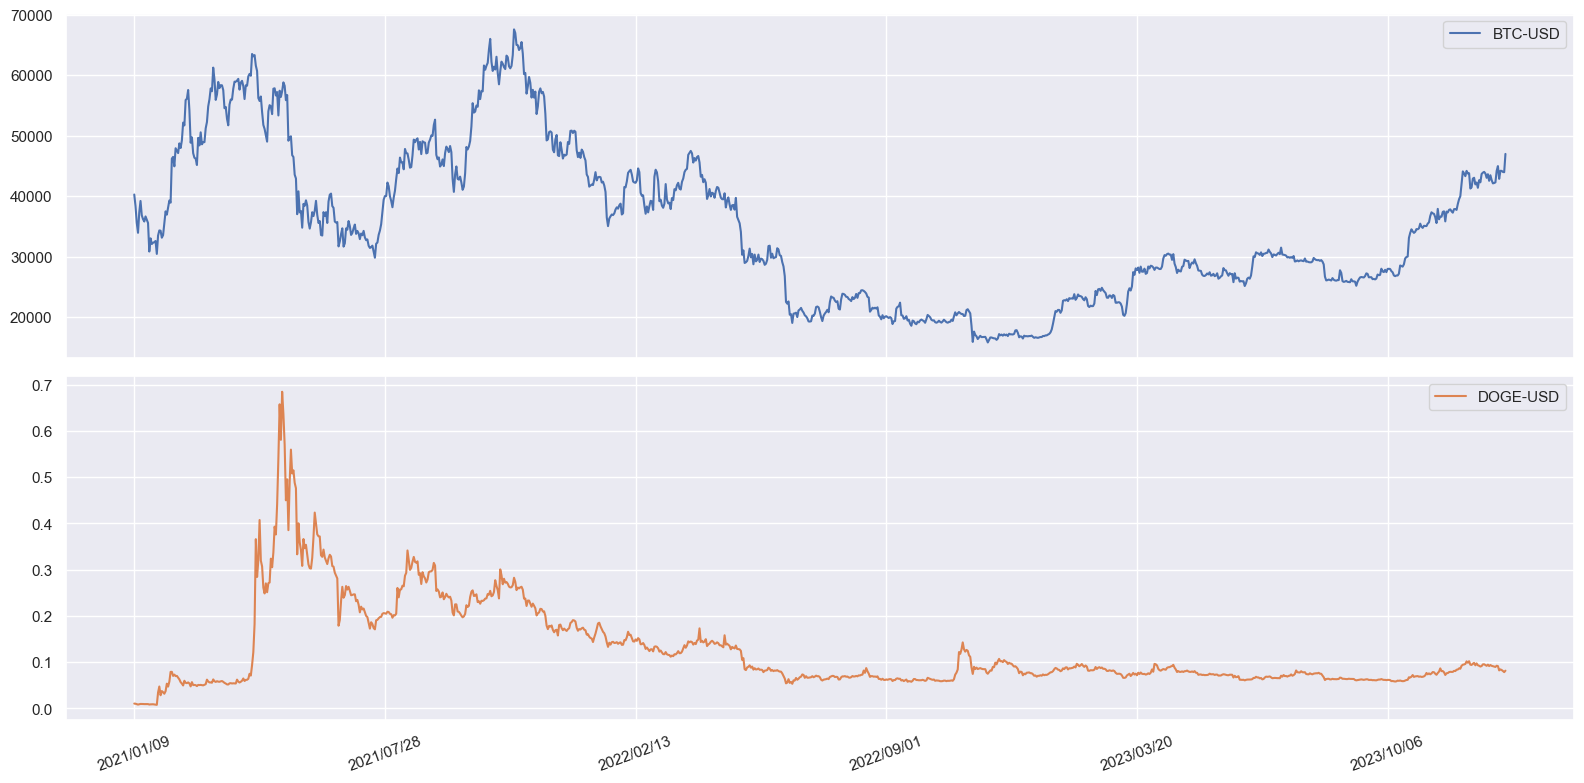

In [13]:
port.plot(subplots=True, figsize =(16, 8))
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# First Difference of Daily Prices of Bitcoin and Dogecoin between 2020 and 2023

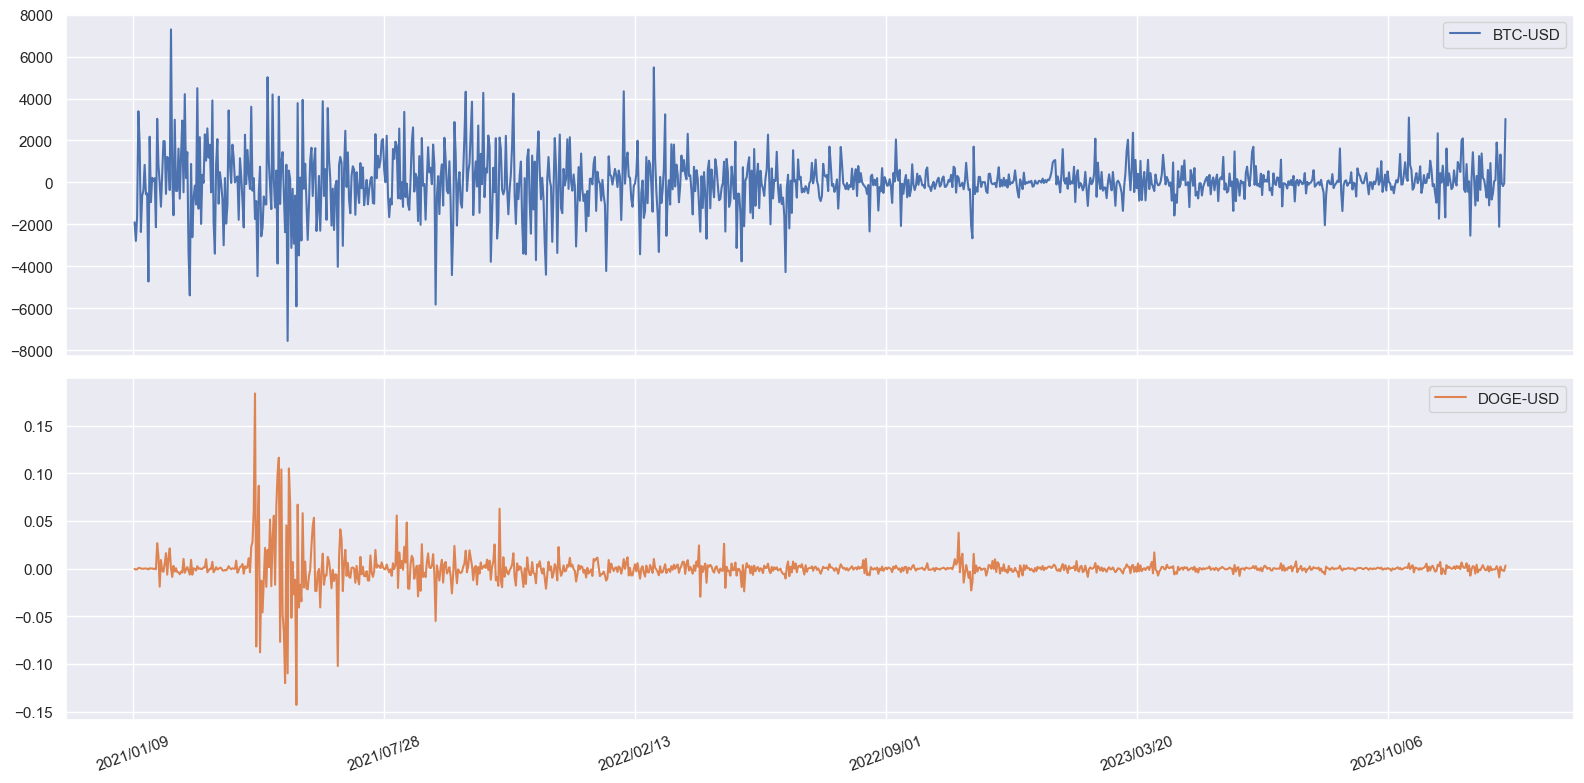

In [14]:
port_firstdiff=port.diff()
port_firstdiff.plot(subplots=True,figsize=(16, 8))
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

We reject the null hypothesis in favor of the alternative hypothesis and come to the conclusion that the first difference between the bitcoin and dogecoin data is either stationary or does not have a unit root when we take their first difference, which causes the p-value of the ADF statistics to change to 5.9056e-14 and 2.6773e-13, respectively. For more information, refer to the table below:



# Importing the Data for Dogecoin and Bitcoin Prices

[*********************100%%**********************]  1 of 1 completed


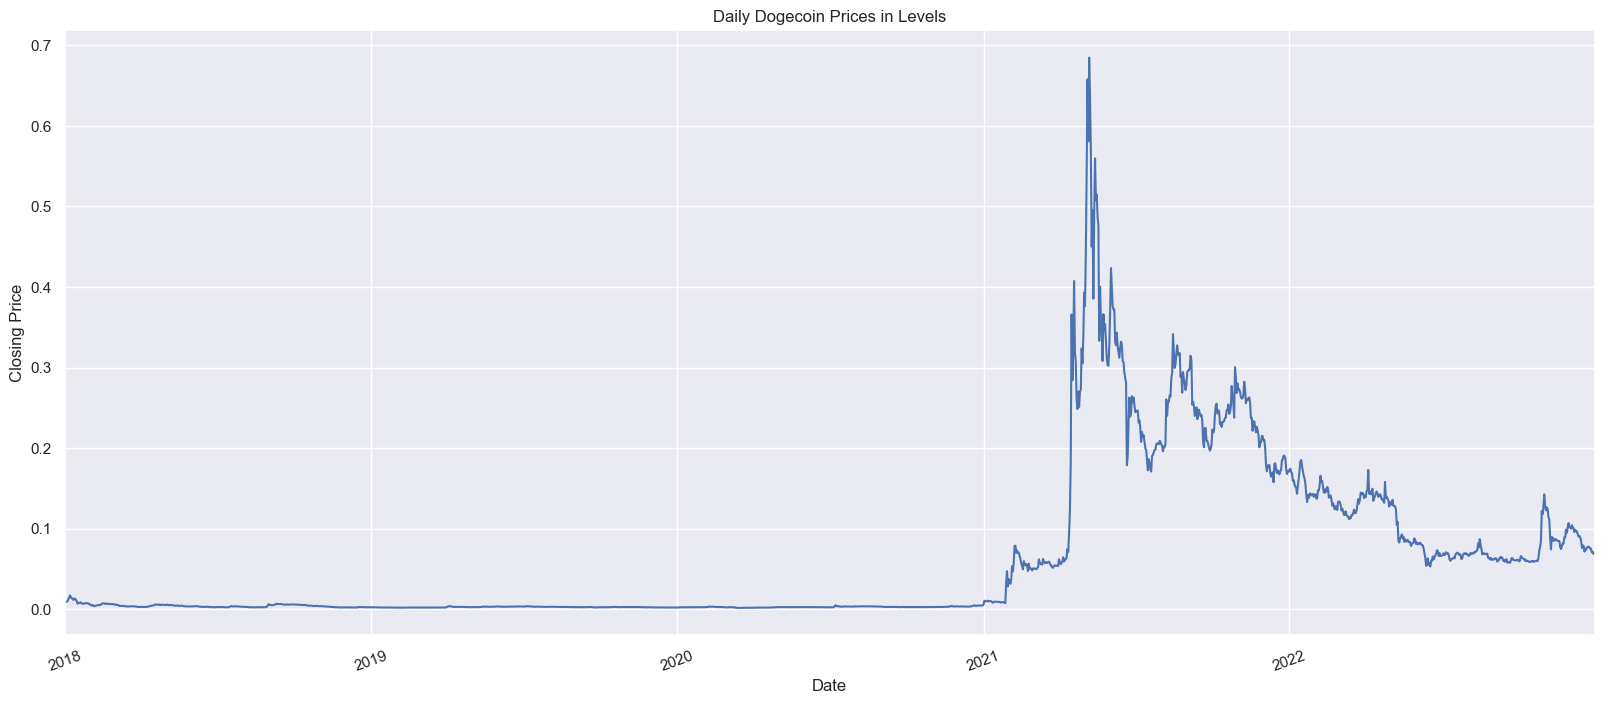

In [15]:
# Importing the Data for Dogecoin Prices

## Defining the ticker symbol for the S&P 500 index
ticker_symbol_1 = "DOGE-USD"

## Setting the start and end dates for the data
start_date = "2018-01-01"
end_date = "2023-01-01"

## Fetching the historical data for the S&P 500 index
data_1 = yf.download(ticker_symbol_1, start=start_date, end=end_date)

# Extracting the "Close" column from the data
closing_prices_1 = data_1["Close"]

# Plotting the S&P 500 closing prices over time
closing_prices_1.plot(subplots=True, figsize =(16, 7))
plt.xticks(rotation=20)
plt.tight_layout()
plt.title("Daily Dogecoin Prices in Levels")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed


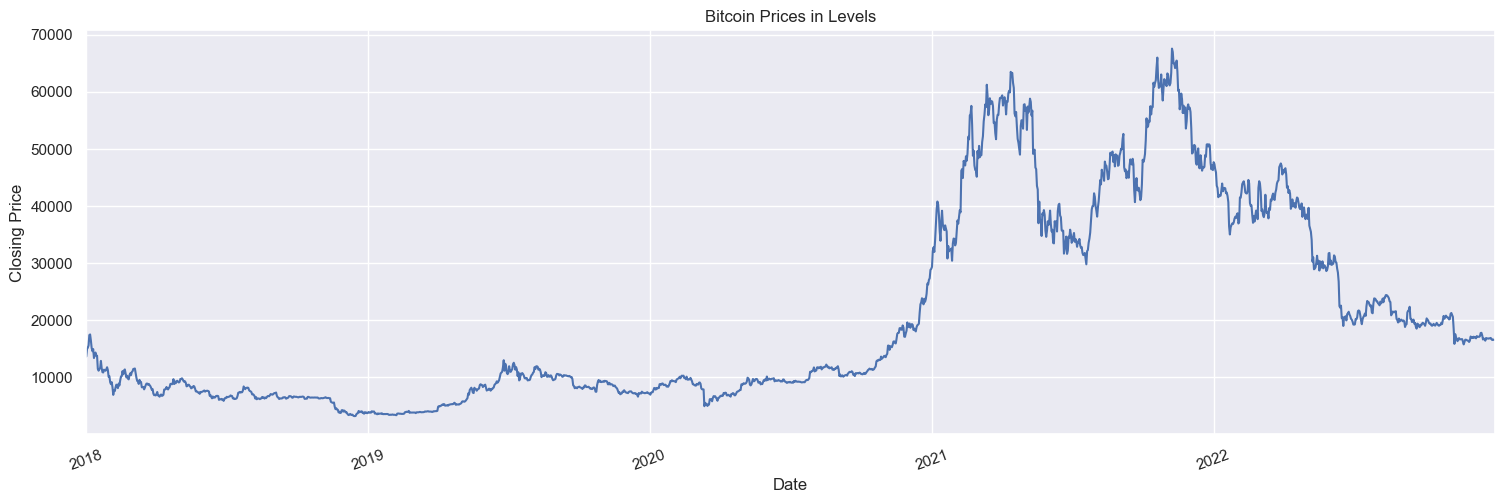

In [16]:
# Defining the ticker symbol for the S&P 500 index
ticker_symbol_2 = "BTC-USD"

# Setting the start and end dates for the data
start_date = "2018-01-01"
end_date = "2023-01-01"

# Fetching the historical data for the S&P 500 index
data_2 = yf.download(ticker_symbol_2, start=start_date, end=end_date)

# Extracting the "Close" column from the data
closing_prices_2 = data_2["Close"]

# Plotting the S&P 500 closing prices over time
closing_prices_2.plot(subplots=True, figsize =(15, 5))
plt.xticks(rotation=20)
plt.tight_layout()
plt.title("Bitcoin Prices in Levels")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()

# Performing the Augmented Dickey Fuller (ADF) Test on Dogecoin Prices in Levels

In [17]:
# Perform the ADF test
result = adfuller(closing_prices_1)

# Extract and print the test statistics
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

ADF Statistic: -2.495383094487467
p-value: 0.11660171289045229
Critical Values:
1%: -3.4339881389288407
5%: -2.863147035877915
10%: -2.567625533641975


# Performing the Augmented Dickey Fuller (ADF) Test on Bitcoin Prices in Levels

In [18]:
# Perform the ADF test
result = adfuller(closing_prices_2)

# Extract and print the test statistics
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

ADF Statistic: -1.3680901469283666
p-value: 0.5974749358209467
Critical Values:
1%: -3.4339861159726306
5%: -2.863146142843122
10%: -2.5676250581282964


# The plot for the First Difference of Dogecoin prices

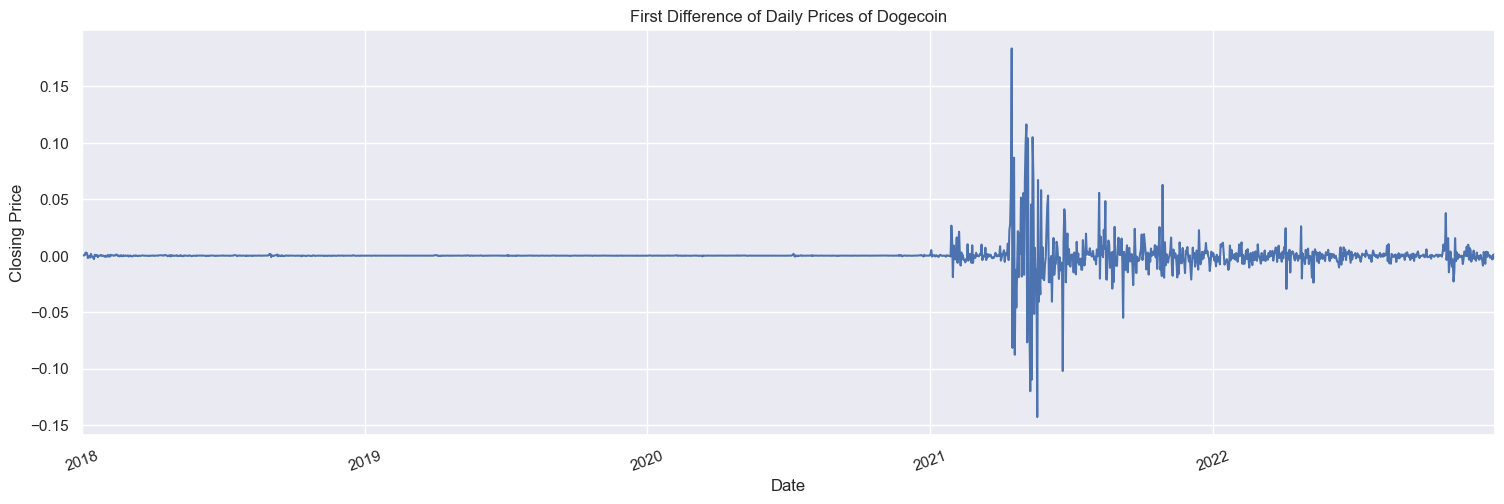

In [19]:
closing_prices_1_firstdiff=closing_prices_1.diff()
closing_prices_1_firstdiff.plot(subplots=True,figsize=(15, 5))
plt.xticks(rotation=20)
plt.tight_layout()
plt.title("First Difference of Daily Prices of Dogecoin")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()


# Performing the Augmented Dickey Fuller (ADF) Test on First Difference of Bitcoin prices

In [20]:
# Perform the ADF test
result = adfuller(closing_prices_1_firstdiff.dropna())

# Extract and print the test statistics
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

ADF Statistic: -8.626647673574048
p-value: 5.905654129247436e-14
Critical Values:
1%: -3.433990164137254
5%: -2.8631479299063405
10%: -2.567626009684832


# The plot for the First Difference of Bitcoin prices

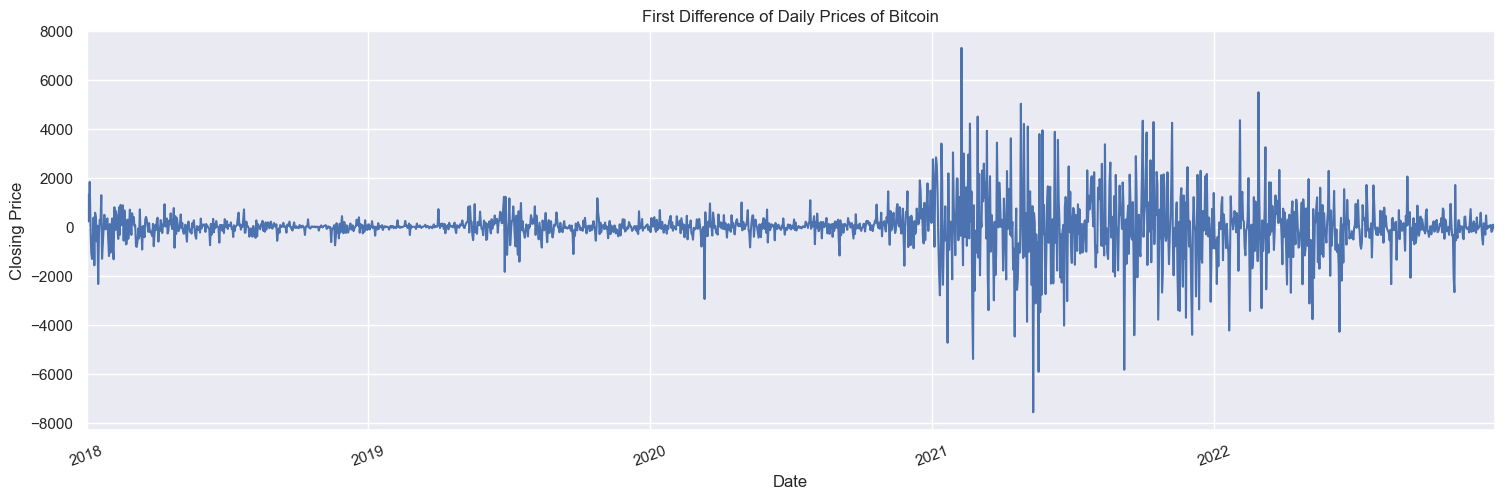

In [21]:
closing_prices_2_firstdiff=closing_prices_2.diff()
closing_prices_2_firstdiff.plot(subplots=True,figsize=(15, 5))
plt.xticks(rotation=20)
plt.tight_layout()
plt.title("First Difference of Daily Prices of Bitcoin")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()

# Performing the Augmented Dickey Fuller (ADF) Test on First Difference of Bitcoin Prices

In [22]:
# Perform the ADF test
result = adfuller(closing_prices_2_firstdiff.dropna())

# Extract and print the test statistics
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

ADF Statistic: -8.370056666580407
p-value: 2.677309781038027e-13
Critical Values:
1%: -3.4339861159726306
5%: -2.863146142843122
10%: -2.5676250581282964


# Engle-Granger cointegration

To verify cointegration, we move on to using the two-step Engle-Granger test. The regression model is first estimated in (2), the residuals are obtained, and we use the ADF test to see if the residual is stationary at level form. If it is, we draw the conclusion that the variables are cointegrated. The steps involved in hypothesis testing are as follows:

H0: There is no cointegration of variables


H1: Cointegration of the variables

In [23]:
# Add a constant to the independent variable for the cointegration test
X = sm.add_constant(closing_prices_2_firstdiff.dropna())

# Fit an OLS model for the cointegration test
model = sm.OLS(closing_prices_1_firstdiff.dropna(), X)
results = model.fit()

# Perform the Engle-Granger cointegration test
eg_test = sm.tsa.stattools.coint(closing_prices_2_firstdiff.dropna(), closing_prices_1_firstdiff.dropna(), trend='c', maxlag=1, autolag=None)
# trend='c' indicates a constant term, maxlag is the maximum lag order to check for cointegration,
# and autolag=None specifies to use the user-specified maxlag value

# Print the test results
print("Engle-Granger Cointegration Test Results:")
print("Test statistic:", eg_test[0])
print("P-value:", eg_test[1])
print("Critical values:", eg_test[2])

Engle-Granger Cointegration Test Results:
Test statistic: -30.472180003344832
P-value: 0.0
Critical values: [-3.90245441 -3.33948189 -3.04677604]


The above results demonstrate that the cryptocurrencies have an equilibrium relationship. The magnitude of the coefficient (-0.0895) represents the speed of adjustment. Therefore, the error correction mechanism suggests that for the daily prices of the cryptocurrencies, deviations from the long-run equilibrium between Dogecoin and Bitcoin is corrected by 8.9% per unit time. The statistical significance of the coefficient strengthens the interpretation that there is a meaningful and significant adjustment process towards equilibrium.

In [24]:
# Error Correction Model

# Estimate the ECM
model = sm.OLS(closing_prices_1_firstdiff.dropna(), X)
results = model.fit()

# Extract the residuals (error term)
residuals = results.resid

# Create lagged variables
lagged_residuals = residuals.shift(1)  # Use lagged residuals as an independent variable

# Combine the lagged residuals with the original independent variables
X_ecm = pd.concat([X, lagged_residuals], axis=1).dropna()

# Estimate the ECM
model_ecm = sm.OLS(closing_prices_1_firstdiff.dropna()[1:], X_ecm)
results_ecm = model_ecm.fit()

# Print the ECM results
print(results_ecm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     158.9
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           2.37e-64
Time:                        22:16:54   Log-Likelihood:                 5584.5
No. Observations:                1824   AIC:                        -1.116e+04
Df Residuals:                    1821   BIC:                        -1.115e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.95e-05      0.000      0.111      0.9


## 1.5 Diagram

All econometric modeling involves certain fundamental assumptions about the underlying process that produces the data; conclusions from the model are only meaningful if it closely resembles the behavior of the process that produces the data. We present the modus operandi in the main paper to diagnose the process for modeling non-stationarity and determining an equilibrium.

The process of modeling non-stationarity and determining equilibrium is conceptualized in the diagram. Stage 1 comprises applying the Augmented Dickey Fuller (ADF) test to determine whether cryptocurrencies are stationar. We fit a regression model based on whether the variables are stationary in levels or of order 0, or I (0). However, we say the variables are integrated of order 1, or I(1), if they remain stationary after applying the first difference transformation. If so, we move on to Stage 2. Nevertheless, if none of the variables are stationary of order I(1), we can use I(2), the second difference transformation, until we achieve stationarity. As a result, there are circumstances in which stationarity can be reached by using the fifth difference transformation, or I(5).

In our instance, we discover that following the first difference, the cryptocurrencies are stationary. The next action is to determine whether a long-term relationship exists. Finding out if the cryptocurrencies are cointegrated is what is meant by this. We'll use the following two methods to look for cointegration.

The two-step Engle-Granger test is widely used to assess cointegration between two variables. The procedures involve finding the residuals for the regression model and estimating the regression model for the cryptocurrencies in equation (4). The next step is to determine whether these residuals are stationary at level form using the ADF test. The variables are cointegrated if they are stationary in level form (Engle and Granger, 1987). When two variables are I(1), we typically use the Engle-Granger cointegration method. The error correction model (ECM), which is used to analyze both the short-term dynamics and the long-term equilibrium into the analysis, is a supplement to the Engle-Granger cointegration procedure. An error correction term that measures how quickly the system adjusts for departures from equilibrium is incorporated into the ECM. The error correction term will apply pressure to return the prices of the two cryptocurrencies to their long-term equilibrium if they deviate from it. The error correction term's magnitude and significance offer information about the strength and speed of the adjustment process leading to equilibrium.

It is sufficient to mention that models with more than two variables may not be suitable for the Engle-Granger method of cointegration, which is meant for models with only two variables. For multivariate cases involving multiple variables (more than two), we rely on the Johansen test. To determine whether two cryptocurrencies are cointegrated, let's say we add Ethereum (ETH-USD) to the current framework. To do this, we would need to apply the Johansen cointegration test procedure. Choosing an ideal lag based on the Akaike's Information Criterion (AIC) is one component of the Johansen cointegration test at stage 3. Finding the model's Vector Error Correction (VEC) cointegrating rank is the other important factor. The maximum eigen-value method and the trace test are used for this (Johansen, 1991). In the event that cointegration cannot be detected, the researcher will move on to Stage 3a; if not, Stage 3b. The causality test is essentially conducted in stages 3a and 3b. If the variables are cointegrated, a Vector Autoregressive (VAR) model will be used; otherwise, a Vector Error Correction (VEC) model will be used.

## 1.5 Diagnosis

See the plots of these cryptocurrencies' daily prices in levels and after taking the first difference to show that the chosen cryptocurrencies are beneficial for this group project.

First off, time series analysis benefits from the rare chance for high frequency data that daily prices provide (Gujarati, 2018; Brooks, 2019). This is so that a larger sample size can be obtained from high frequency data. We also observe notable fluctuations during the COVID-19 pandemic. These variations are not subject to governmental or capital constraints; instead, they are determined exogenously.

Looking at the diagrams imperatively suggests that the initial plots of the daily prices of Bitcoin (BTC-USD) and Dogecoin (DOGE-USD) lack constant autocovariances, constant variance, and constant mean, which are characteristics of time series data that point to non-stationarity. Plots are mean reverting and show comparatively stable variance and autocovariances after taking their first difference. Using suitable hypothesis testing techniques, such as the Augmented Dickey-Fuller (ADF) test, we will empirically show the non-stationarity and stationarity of the corresponding time series in section 3.
The Johansen cointegrated test and the Engel and Granger method will also be used to show whether the variables are cointegrated. Based on the findings of the Johansen cointegration test, we will then use the Vector Autoregressive (VAR) and Vector Error Correction (VEC) methods. Finally, to determine whether the lags in one variable conditionally aid in the prediction of another, we will apply the Granger causality tests (Gujarati and Porter, 2009).

## 1.6 Damage
The Engle Granger method is not appropriate for multivariate cases with more than two variables, as we point out in section 1.4. This is due to the Engle-Granger method's restriction on cointegration testing (bivariate analysis) between two variables. Cases with more than two variables are beyond its capabilities (Gujarati, 2009). On the other hand, multivariate analysis, or the analysis of cointegration among multiple variables, is made possible by the Johansen test. Economic relationships often involve more than two variables in real-world scenarios. The Johansen (1991) method is the maximum likelihood for finite-order vector autoregressions (VARS) and can be computed with ease for systems that are able to identify multiple cointegrating vectors, if any, and capture complex interrelationships among multiple variables. Because of this, it is usually regarded as being more reliable and effective than the Engle-Granger test, especially when working with bigger sets of variables.

## 1.7 Directions
In order to replicate a real-world situation, let's introduce Ethereum (ETH-USD) as a third cryptocurrency. In order to create a lasting relationship between the cryptocurrencies, we will undoubtedly need to use the Johansen Cointegration procedure. For the Johansen cointegration test protocol, refer to the following:

### 1.7.1 Process for Selecting Lag
Choosing a suitable lag length is the first step in the Johansen Cointegration process, and it has a substantial impact on the result (Johansen, 1991; Johansen and Juselius, 1990). We apply the Akaike Information Criterion (AIC), a frequently used criterion for lag selection in single-variable distributed-lag models, to ascertain the lag length. The AIC has shown good performance in Monte Carlo studies and is especially well-suited for small sample sizes (Kennedy, 2003). It is crucial to remember that different criteria might not always agree on the ideal lag duration. In these situations, some degree of discretion might be required. It is important to make sure that the lag length selected produces residuals that are similar to white noise because only then can trustworthy conclusions be made. To attain practical usefulness in estimation, therefore, extra lags are added if necessary (Toda and Yamamoto, 1995).

However, adding more lags has disadvantages. Concerns regarding the accuracy of parameter estimates may arise from a loss of degrees of freedom and an upward bias in the test statistic caused by a high-order VAR or lag length. However, in real life, scientists would rather have a white noise error term than fewer degrees of freedom. Using standard Wald test statistics to determine whether the coefficients at each lag are all zero is another method for choosing an appropriate lag length (Tiwari, 2011).

### 1.7.2 Johansen Cointegration Test Trace/Maximum Eigen Value Statistic
Using the Trace and Maximum Eigenvalue statistics, we can ascertain the number of cointegrating vectors, indicated by r0, once we have a VAR model with the appropriate number of lags and white noise residuals. Equations (3) and (4) define the statistics for the Trace test and Maximum Eigenvalue test, respectively, as stated in the work of Johansen and Juselius (1990).

Following Gujarati and Porter's (2009) methodology, we perform Granger causality tests using a VAR (Vector Autoregressive) model to ascertain whether lagged values of one variable can predict another variable. Granger (1969) established that these causality tests are valid and trustworthy when the variables being examined are not cointegrated. Chang (2010) suggests using differenced data for the causality tests in situations where the variables are not cointegrated. The VAR model, as described in the main paper, is used in our particular situation.

In this case, the following criteria are used to determine causation: The chi-square statistics would be used to conduct the hypothesis test. The prices of Dogecoin and Ethereum granger influence the price of Bitcoin if the values of the α coefficients are significant but the values of the β and γ coefficients are not. In a similar vein, Dogecoin prices are influenced by the prices of Bitcoin and Ethereum if the β coefficient values are significant but the α and γ coefficient values are not. In light of this, Ethereum is caused by the prices of Bitcoin and Dogecoin if the γ coefficient values are significant while the α and β coefficient values are not. Additionally, the model (4) option under the Python "Cointegration Test Specification" was selected by the author, allowing for an intercept and no trend in the test VAR and Cointegrating Equation (CE). This was due to the fact that we detrended all of the relevant variables and allowed for an intercept at the first difference when we discovered stationarity for all of the variables in this paper.

## Import Data for Ethereum Prices

[*********************100%%**********************]  1 of 1 completed


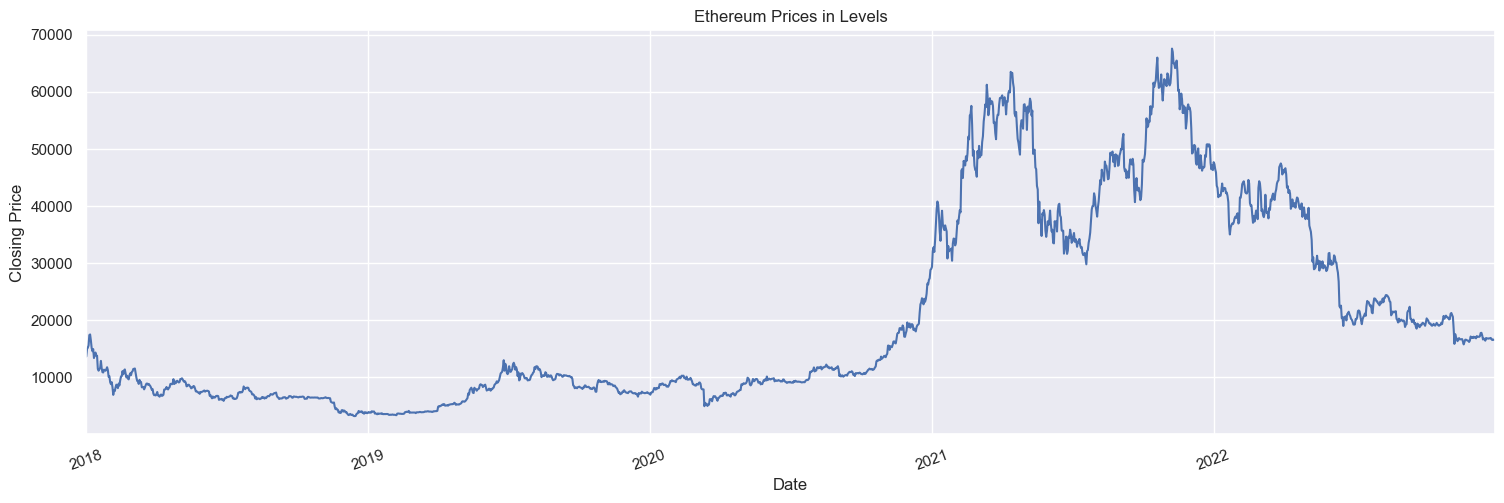

In [25]:
# Defining the ticker symbol for the S&P 500 index
ticker_symbol ="ETH-USD"

# Setting the start and end dates for the data
start_date = "2018-01-01"
end_date = "2023-01-01"

# Fetching the historical data for the S&P 500 index
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Extracting the "Close" column from the data
closing_prices_3 = data["Close"]

# Plotting the S&P 500 closing prices over time
closing_prices_2.plot(subplots=True, figsize =(15, 5))
plt.xticks(rotation=20)
plt.tight_layout()
plt.title("Ethereum Prices in Levels")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()

## The plot for the First Difference of Ethereum prices

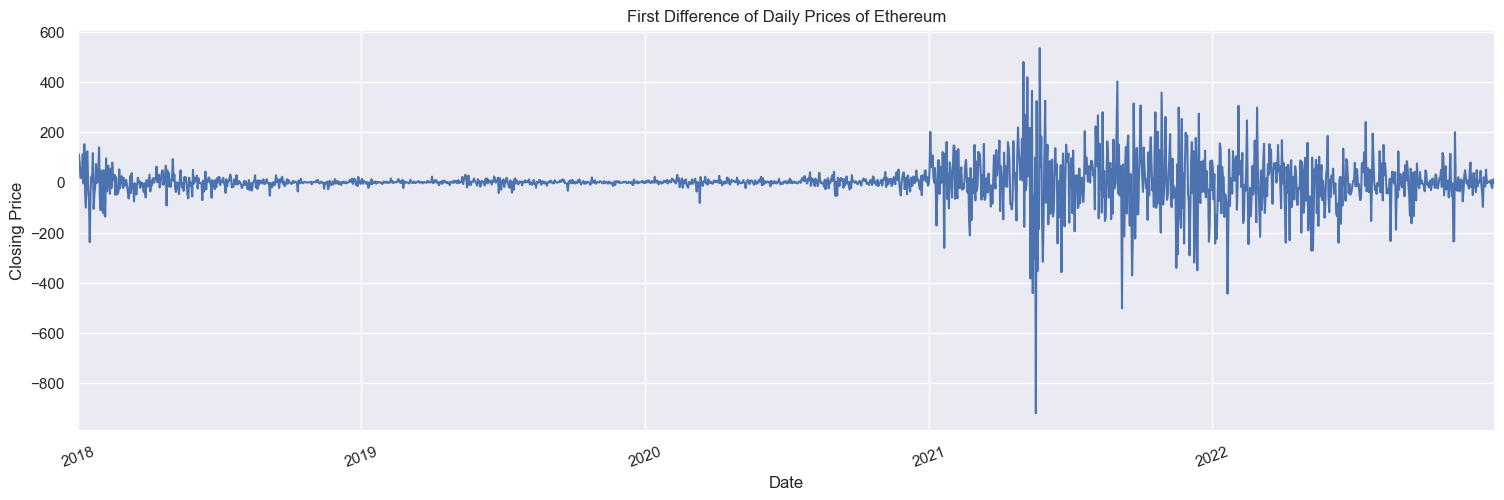

In [26]:
closing_prices_3_firstdiff=closing_prices_3.diff()
closing_prices_3_firstdiff.plot(subplots=True,figsize=(15, 5))
plt.xticks(rotation=20)
plt.tight_layout()
plt.title("First Difference of Daily Prices of Ethereum")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()

## Performing the Augmented Dickey Fuller (ADF) Test on Ethereum Prices in Levels

In [27]:
# Perform the ADF test
result = adfuller(closing_prices_3.dropna())

# Extract and print the test statistics
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

ADF Statistic: -1.3247721050452523
p-value: 0.61776423271554
Critical Values:
1%: -3.433972018026501
5%: -2.8631399192826676
10%: -2.5676217442756872


## Performing the Augmented Dickey Fuller (ADF) Test on First Difference of Ethereum Prices

In [28]:
# Perform the ADF test
result = adfuller(closing_prices_3_firstdiff.dropna())

# Extract and print the test statistics
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

ADF Statistic: -10.658628544238056
p-value: 4.4665283603920075e-19
Critical Values:
1%: -3.433972018026501
5%: -2.8631399192826676
10%: -2.5676217442756872


## Importing all the Cryptocurrencies as a Vector

In [29]:
def stock_Data(ls,start_date,end_date):
    data=pd.DataFrame()
    for i in ls:
        st=yf.download(i, start=start_date, end=end_date)["Adj Close"]
        st=st.reindex(st.index.strftime('%Y/%m/%d')).rename(i)
        data=pd.concat([data,st],axis=1)
    return data

In [30]:
stock = ["BTC-USD","DOGE-USD","ETH-USD"]
end_date = date.today()
start_date = end_date - timedelta(days=365.25*3)
df=stock_Data(stock,start_date,end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [31]:
portfolio=df.dropna(axis = 0, how = 'any')
portfolio

,BTC-USD,DOGE-USD,ETH-USD
2021/01/09,40254.546875,0.010194,1281.077271
2021/01/10,38356.441406,0.009860,1262.246704
2021/01/11,35566.656250,0.008835,1090.145386
2021/01/12,33922.960938,0.008063,1043.434570
2021/01/13,37316.359375,0.008616,1130.739380
...,...,...,...
2024/01/04,44179.921875,0.084131,2269.038086
2024/01/05,44162.691406,0.082773,2268.647217
2024/01/06,43989.195312,0.080664,2241.624756
2024/01/07,43943.097656,0.078225,2222.865967


# Johansen Cointegration Model Lag Selection and Johansen Cointegration Test

In [32]:
# Specify the range of lag orders to test
min_lag = 1
max_lag = 3

# Initialize variables for best lag order and minimum AIC
best_order = 0
min_aic = float('inf')

# Iterate over lag orders and select the best one based on AIC
for lag_order in range(min_lag, max_lag + 1):
    model = VAR(portfolio)
    results = model.fit(maxlags=lag_order)
    aic = results.aic

    print("Lag Order:", lag_order)
    print("AIC:", aic)

    if aic < min_aic:
        min_aic = aic
        best_order = lag_order

# Print the lag order selection results
print("Best Lag Order:", best_order)
print("Minimum AIC:", min_aic)

Lag Order: 1
AIC: 14.150954255400666
Lag Order: 2
AIC: 14.129568673775772
Lag Order: 3
AIC: 14.109656726152988
Best Lag Order: 3
Minimum AIC: 14.109656726152988


In [33]:
# Specify the lag order for cointegration test
lag_order = 3

# Create the lagged variables
lagged_variables = portfolio.shift(lag_order).dropna()

# Perform the Johansen cointegration test
johansen_results = coint_johansen(lagged_variables, det_order=0, k_ar_diff=lag_order-1)  # Adjust parameters as needed

# Print the test results
print("Johansen Cointegration Test Results:")
print("Eigenvalues:", johansen_results.eig)
print("Eigenvalue Test Statistic:", johansen_results.lr1)
print("Critical Values (90%, 95%, 99%):", johansen_results.cvt)
print("Trace Statistic:", johansen_results.lr2)
print("Critical Values (90%, 95%, 99%):", johansen_results.cvm)

Johansen Cointegration Test Results:
Eigenvalues: [0.02439314 0.0160256  0.00412382]
Eigenvalue Test Statistic: [48.98684069 22.09335794  4.50012675]
Critical Values (90%, 95%, 99%): [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Trace Statistic: [26.89348276 17.59323118  4.50012675]
Critical Values (90%, 95%, 99%): [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


## Number of Cointegrating Rank of VECM

In [34]:
# Get the number of cointegrating ranks
threshold = 0.05  # Set your desired threshold value
num_ranks = sum(johansen_results.eig > threshold)
print("Number of Cointegrating Ranks:", num_ranks)

Number of Cointegrating Ranks: 0


## 1.8 Deployment

The main modification we made to our model was adding Ethereum (ETH-USD), a different cryptocurrency. To be thorough, we also verify that Ethereum prices are stationary at first difference.

Based on the outcomes of the Python script, 4 was determined to be the ideal lag length, with an approximate minimum AIC of 13.946. We do not reject the null hypothesis, which indicates that there is no cointegrating rank of VEC for the cryptocurrencies based on Trace/Maximum Eigen Value Statistic for Johansen Cointegration Test analysis in the Python Script. The Granger-causality tests for cryptocurrencies will be estimated using a VAR model since the Johansen cointegration test procedure does not reveal a long run relationship.

## Implement the VAR model

In [35]:
# Specify the lag order for the VAR model
lag_order = 3

# Fit the VAR model
model = VAR(portfolio)
results = model.fit(lag_order)

# Print the VAR model summary
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Jan, 2024
Time:                     22:17:23
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    14.2469
Nobs:                     1092.00    HQIC:                   14.1616
Log likelihood:          -12322.3    FPE:                1.34198e+06
AIC:                      14.1097    Det(Omega_mle):     1.30578e+06
--------------------------------------------------------------------
Results for equation BTC-USD
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             198.239319       120.297243            1.648           0.099
L1.BTC-USD          1.039652         0.048984           21.224           0.000
L1.DOGE-USD       581.426123      2786.893962            0.209    

## Carry out VAR Granger Causality Test

In [36]:
# Specify the lag order for the VAR model
lag_order = 3

# Fit the VAR model
model = VAR(portfolio)
results = model.fit(lag_order)

# Perform the Granger causality test
causality_test = results.test_causality('DOGE-USD', ['BTC-USD'], kind='f')

# Print the causality test results
print("Granger Causality Test Results:")
print(causality_test)

Granger Causality Test Results:
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: BTC-USD does not Granger-cause DOGE-USD: reject at 5% significance level. Test statistic: 5.850, critical value: 2.608>, p-value: 0.001>


The results above suggest that Bitcoin prices granger-causes Ethereum prices. However, we do not find any evidence a feedback or bidirectional granger causality between the prices of Bitcoin and Ethereum. Similarly, we did not find any evidence of causality between Bitcoin and Dogecoin prices as well as for Dogecoin and Ethereum prices.